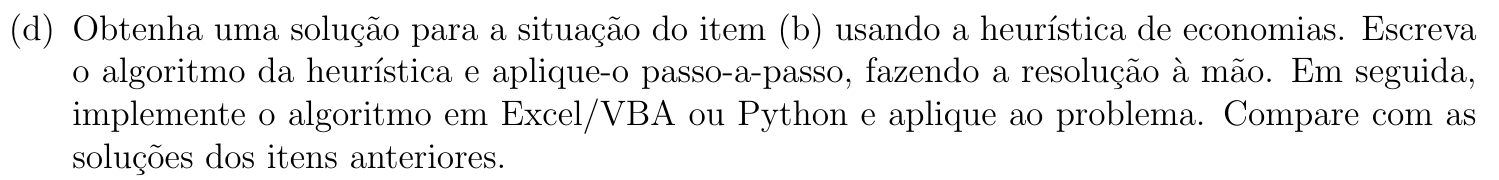

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='images/1d.png')

## Heurística de economias

In [1]:
# Bibliotecas
import xlwings as xw

In [2]:
# Planilha
wb = xw.Book('prv_vba_v0.xlsm')
sheet = wb.sheets['PRV']

In [3]:
# Conjuntos
Clientes = sheet.range('D4:H4').options(numbers=int).value
Nos = sheet.range('C4:I4').options(numbers=int).value
n = sheet.range('C2').options(numbers=int).value

In [4]:
# Dados
# Matriz de custos / tempo de viagem
matriz = sheet.range('C6:I12').value
# Demanda
demanda = sheet.range('C14:I14').value
# Instante de inicio de serviço
janela_inicio = sheet.range('C15:I15').value
janela_inicio = [e * 60 for e in janela_inicio]  # Conversão para minutos
# Instante do fim do serviço
janela_fim = sheet.range('C16:I16').value
janela_fim = [e * 60 for e in janela_fim]  # Conversão para minutos
# Tempo de serviço
tempo_servico = sheet.range('C17:I17').value
# Capacidade de transporte de cada caminhão
capacidade = sheet.range('G2').value

### Funções

In [5]:
def par(clientes):
    """Lista de possíveis pares de cidades para viagem"""
    par = []
    for i in Clientes:
        for j in Clientes:
            if i != j:
                par.append((i, j))
    return par

In [6]:
def economia(clientes, s, custo):
    """Cálculo das economias para cada arco da rota"""
    economias = []
    for i in clientes:
        for j in clientes:
            if i != j:
                economias.append(custo[0][j] + custo[i][n + 1] - custo[i][j])
    
    # Criação de dicionário com as chaves de s e valores de economias:
    economia_dict = dict(zip(s, economias))
    
    return economia_dict

In [7]:
def preenche_economias(economias):
    """Preenchimento das economias no excel"""
    sheet.range('K6:M25').clear_contents()  # Limpa a tabela de economias
    executa = True
    
    linha = 0
    for par in economias:
        i = par[0][0]
        j = par[0][1]
        s_ij = par[1]
        sheet.range(f'K{6 + linha}:M{6 + linha}').value = [i, j, s_ij]
        linha += 1
        
    return executa

In [8]:
def check_capacidade(rota):
    """Verifica a restrição de capacidade para uma rota"""
    clientes = rota[1:-1]
    cap = 0
    for i in clientes:
        cap += demanda[i]
    
    if cap <= capacidade:
        return True
    
    return False

In [9]:
def check_janelas(rota, tempo_inicial=420):
    """Verifica as restrições de janela de tempo"""
    tempo = tempo_inicial
    for k in range(len(rota)):
        if k < len(rota) - 1:
            i = rota[k]
            j = rota[k + 1]  

            if tempo + matriz[i][j] <= janela_fim[j]:
                tempo = max(tempo + matriz[i][j] + tempo_servico[j], janela_inicio[j] + tempo_servico[j])
            else:
                return False
    return True

In [10]:
def rota(i):
    """Retorna o id da rota em que o cliente i está inserido"""
    r = 0
    for rota in rotas:
        if i in rota:
            return r
        r += 1

In [11]:
def sai_deposito(i):
    """Checa se o cliente é visitado logo após o caminhão sair do depósito"""
    if i == rotas[rota(i)][1]:
        return True
    return False

In [12]:
def volta_deposito(i):
    """Checa se o cliente é visitado antes do depósito"""
    if i == rotas[rota(i)][-2]:
        return True
    return False

### Heurística

In [13]:
# Lista com os pares de i e j válidos para o problema
pares = par(Clientes)

In [14]:
# 1. Cálculo das economias
economias = economia(Clientes, pares, matriz)

In [15]:
# 2. Lista ordenada em ordem decrescente de economia
economias = sorted(economias.items(), key=lambda x: x[1], reverse=True)
# Preenche no excel
preenche_economias(economias)

True

In [16]:
# 3. Marca todos os clientes como não atendidos
atendidos = {c: 0 for c in Clientes}

In [17]:
rotas = []

## Loop

In [18]:
# Enquanto a lista de economias não estiver vazia
while len(economias) > 0:
    # 4 Seleciona o arco (i, j) com maior s_ij (economia)
    arco = economias[0][0]
    i = arco[0]
    j = arco[1]
    
        # 4.1 
    # Caso em que ambos não foram atendidos
    if atendidos[i] == 0 and atendidos[j] == 0:
        rota_temp = [0, i, j, n+1]
        if check_capacidade(rota_temp):
            if check_janelas(rota_temp):
                rotas.append(rota_temp)
                atendidos[i], atendidos[j] = 1, 1

        # 4.2
    # Caso em que apenas um foi atendido
    if atendidos[i] != atendidos[j]:
        # Caso o primeiro seja atendido
        if atendidos[i] == 1:
            if volta_deposito(i):
                rota_temp = [0] + rotas[rota(i)][1:-1] + [j] + [n + 1]
                if check_capacidade(rota_temp):
                    if check_janelas(rota_temp):
                        rotas.remove(rotas[rota(i)])
                        rotas.append(rota_temp)
                        atendidos[j] = 1
        # Caso o segundo seja atendido
        elif atendidos[j] == 1:
            if sai_deposito(j):
                rota_temp = [0] + [i] + rotas[rota(j)][1:-1] + [n + 1]
                if check_capacidade(rota_temp):
                    if check_janelas(rota_temp):
                        rotas.remove(rotas[rota(j)])
                        rotas.append(rota_temp)
                        atendidos[i] = 1

        # 4.3
    # Caso em que ambos foram atendidos
    elif atendidos[i] == 1 and atendidos[j] == 1:
        # Se estão em rotas diferentes
        if rota(i) != rota(j):
            if volta_deposito(i) and sai_deposito(j):
                rota_temp = [0] + rotas[rota(i)][1:-1] + rotas[rota(j)][1:-1] + [n + 1]
                if check_capacidade(rota_temp):
                    if check_janelas(rota_temp):
                        rotas.remove(rotas[rota(i)])
                        rotas.remove(rotas[rota(j)])
                        rotas.append(rota_temp)
                        
    # 5 Remove i e j de economias
    economias.pop(0)

In [19]:
# Preenchimento das rotas na planilha
linha = 0
for rota in rotas:
    sheet.range(f'C{19 + linha}:I{19 + linha}').value = rota
    linha += 1